# Credit Risk Modelling: Probability of Default Prediction

This project uses logistic regression to predict probability of borrower default (PD) using Lending Club loan data. It includes data preparation and evaluation tools such as AUC, KS statistic, PSI, and calibration.

**Data source:** Lending Club loan data, https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv

**Contents:**
1. Preparation
2. Model training
3. Evaluation

## 1. Preparation

In [1]:
# Load data
import pandas as pd

df_loans = pd.read_csv('data/loan.csv', low_memory=False)

In [2]:
# Number of loans and features
print("Number of loans:", df_loans.shape[0])
print("Number of features:", df_loans.shape[1])

Number of loans: 2260668
Number of features: 145


In [3]:
# Example loan
print("Example loan:\n")
for col in df_loans.columns:
    print(f"{col:<45} {df_loans.iloc[0][col]}")

Example loan:

id                                            nan
member_id                                     nan
loan_amnt                                     2500
funded_amnt                                   2500
funded_amnt_inv                               2500.0
term                                           36 months
int_rate                                      13.56
installment                                   84.92
grade                                         C
sub_grade                                     C1
emp_title                                     Chef
emp_length                                    10+ years
home_ownership                                RENT
annual_inc                                    55000.0
verification_status                           Not Verified
issue_d                                       Dec-2018
loan_status                                   Current
pymnt_plan                                    n
url                                         

In [4]:
# Loan statuses
print("Loan status values with counts:\n")
df_loans['loan_status'].value_counts()

Loan status values with counts:



loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

### Target

We define the loan statuses "Charged Off" and "Default" as **default**, and "Fully Paid" as **non-default**. Skip others for clarity.

In [5]:
# Filter statuses
target_statuses = ['Fully Paid', 'Charged Off', 'Default']
df_loans_filtered = df_loans[df_loans['loan_status'].isin(target_statuses)].copy()
print("Number of loans after filtering loan statuses:", df_loans_filtered.shape[0])

Number of loans after filtering loan statuses: 1303638


### Encode target

In [6]:
# Encode target: default = 1, non-default = 0
df_loans_filtered['default'] = df_loans_filtered['loan_status'].isin(['Charged Off', 'Default']).astype(int)
print("Shape after target encoding (added binary target):")
df_loans_filtered.shape

Shape after target encoding (added binary target):


(1303638, 146)

### Class distribution

In [7]:
n_loans = len(df_loans_filtered)
non_default, default = df_loans_filtered['default'].value_counts().items()

print("Class distribution:\n")
print(f"non-defaults: {non_default[1]} ({non_default[1] / n_loans:.1%}) ")
print(f"defaults: {default[1]} ({default[1] / n_loans:.1%}) ")

Class distribution:

non-defaults: 1041952 (79.9%) 
defaults: 261686 (20.1%) 


### Features used for prediction

Only variables that were certainly available at the time of loan origination were included. Since most variables were uncertain in this respect, only five features were used: (descriptions from LCDataDictionary.xlsx)

- **annual_inc**         - The self-reported annual income provided by the borrower during registration

- **application_type**   - Indicates whether the loan is an individual application or a joint application with two co-borrowers

- **dti**                - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

- **home_ownership**     - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

- **purpose**            - A category provided by the borrower for the loan request

Example of variables with uncertain time measurements:

- **delinq_2yrs**   - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.  

- **loan_amnt**    - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value  

Other:

- **loan_status** - Current status of the loan      
    *(Target)*
- **issue_d** - The month which the loan was funded     
    *(Used for time-based splitting)*    

In [8]:
selected_vars = [
    'annual_inc',
    'application_type',
    'dti',
    'home_ownership',
    'purpose',
    'default',  # target
    'issue_d',  # for time-based splitting
]
df_model = df_loans_filtered[selected_vars].copy()
print("Shape after selecting variables:\n")
df_model.shape

Shape after selecting variables:



(1303638, 7)

### Missing values

In [9]:
missing_counts = df_model.isna().sum().sort_values(ascending=False)
missing_vars = missing_counts[missing_counts > 0]

total_rows = len(df_model)

if len(missing_vars) > 0:
    print("Variables with missing values:\n")
    for col, count in missing_vars.items():
        percentage = (count / total_rows) * 100
        print(f"{col}: {count} ({percentage:.2%})")
else:
    print("No missing values found")

Variables with missing values:

dti: 312 (2.39%)


In [10]:
# Replace missing dti-values with median of the other dtis
numeric_cols = df_model.select_dtypes(include=['number']).columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(df_model[numeric_cols].median())

In [11]:
# Check missing values again
missing_counts = df_model.isna().sum().sort_values(ascending=False)
missing_vars = missing_counts[missing_counts > 0]

total_rows = len(df_model)

if len(missing_vars) > 0:
    print("Variables with missing values:\n")
    for col, count in missing_vars.items():
        percentage = (count / total_rows) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")
else:
    print("No missing values found")

No missing values found


### One-hot encode categorical features

In [12]:
# Categorical features
print("Categorical features with counts:\n")

print(f"{df_loans_filtered['purpose'].value_counts()}\n")
print(f"{df_loans_filtered['home_ownership'].value_counts()},\n")
print(f"{df_loans_filtered['application_type'].value_counts()}\n")

# Total unique categories across all three categorical features
total_categories = (
    df_loans_filtered['purpose'].nunique() +
    df_loans_filtered['home_ownership'].nunique() +
    df_loans_filtered['application_type'].nunique()
)
print("Total unique categories:", total_categories)

Categorical features with counts:

purpose
debt_consolidation    757610
credit_card           285708
home_improvement       84497
other                  74937
major_purchase         28328
medical                15024
small_business         15010
car                    14121
moving                  9173
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: count, dtype: int64

home_ownership
MORTGAGE    645509
RENT        517821
OWN         139849
ANY            267
OTHER          144
NONE            48
Name: count, dtype: int64,

application_type
Individual    1280394
Joint App       23244
Name: count, dtype: int64

Total unique categories: 22


In [13]:
categorical_cols = ['purpose', 'home_ownership', 'application_type']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"Number of loans after one-hot encoding: {df_model.shape[0]}")
print(f"Number of features after one-hot encoding: {df_model.shape[1]}")

Number of loans after one-hot encoding: 1303638
Number of features after one-hot encoding: 23


### Train/test split

In [14]:
# Time-based Train/test split
df_sorted = df_model.sort_values('issue_d')

split_point = int(0.8 * len(df_sorted))



X_train = df_sorted.iloc[:split_point].drop(['default', 'issue_d'], axis=1)
y_train = df_sorted.iloc[:split_point]['default']
X_test = df_sorted.iloc[split_point:].drop(['default', 'issue_d'], axis=1)
y_test = df_sorted.iloc[split_point:]['default']

print(f"Train period: {df_sorted['issue_d'].iloc[0]} to {df_sorted['issue_d'].iloc[split_point-1]}")
print(f"Test period: {df_sorted['issue_d'].iloc[split_point]} to {df_sorted['issue_d'].iloc[-1]}")

print(f"\nNumber of loans in train period: {len(X_train)}")
print(f"Number of loans in test period: {len(X_test)}")

Train period: Apr-2008 to Nov-2015
Test period: Nov-2015 to Sep-2018

Number of loans in train period: 1042910
Number of loans in test period: 260728


### Standardize features

In [15]:
# Standardize features (mean = 0, sd = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on train set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## 2. Model Training

The logistic regression model estimates the probability of default for each observation as

$$
p(x_1, \dots, x_m) = \frac{1}{1 + \exp\big(-(\beta_0 + \beta_1 x_1 + \dots + \beta_m x_m)\big)},
$$

where $x_1, \dots, x_m$ are the input features, and $\beta_0, \dots, \beta_m$ are the coefficients to be estimated using the training data.

The formula above can be rewritten as

$$
\log\left(\frac{p(\bf{x})}{1 - p(\bf{x})}\right) = \beta_0 + \beta_1 x_1 + \dots + \beta_m x_m,
$$

where $\textbf{x} = (x_1, \dots, x_m)$. This formula shows that inputs $x_i$ that correspond to positive coefficients $\beta_i$ are positively correlated with the probability $p(\bf{x})$.

In [16]:
# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

print("Training done")

Training done


In [17]:
# Make predictions
class_thr = 0.5
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # probabilities
y_pred = (y_pred_proba >= class_thr).astype(int) # binary predictions

print("Predictions done")

Predictions done


## 3. Evaluation

- Accuracy, recall, precision
- Confusion matrix
- ROC AUC
- KS statistic
- Population stability index (PSI)
- Calibration

In [18]:
# Accuracy
from sklearn.metrics import accuracy_score
import numpy as np

accuracy = accuracy_score(y_test, y_pred)
p = np.mean(y_test) # fraction classified as 1 (default)
n_0 = len(y_pred) - np.sum(y_pred)
n_0_frac = n_0 / len(y_pred)

print(f"Accuracy with classification threshold {class_thr}: {accuracy:.3f}")
print(f"Majority-class-acc: {max(p, 1-p):.3f}")
print(f"Number of predictions equal to 0: {n_0} ({n_0_frac:.1%})")

Accuracy with classification threshold 0.5: 0.802
Majority-class-acc: 0.802
Number of predictions equal to 0: 260458 (99.9%)


In [19]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    209178
           1       0.30      0.00      0.00     51550

    accuracy                           0.80    260728
   macro avg       0.55      0.50      0.45    260728
weighted avg       0.70      0.80      0.71    260728



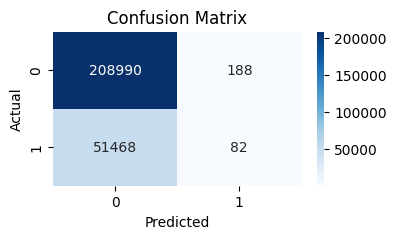

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##

The above metrics are calcuated using a classification threshold of 0.5. Due to the imbalanced class proportions, most loans are therefore predicted as non-defaults. This causes the recall for defaults to be 0. If it is more important to correctly classify default than having good accuracy, a lower threshold should be used.

### AUC and Gini Coefficient

In [21]:
# AUC, Gini
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc - 1
print(f"ROC AUC: {auc:.3f}")
print(f"Gini: {gini:.3f}")

ROC AUC: 0.602
Gini: 0.205


### ROC Curve

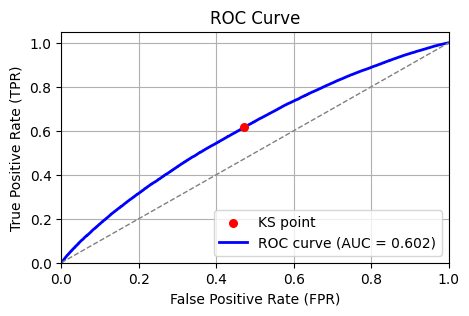

In [22]:
# ROC curve with KS point
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_index = (tpr - fpr).argmax() # KS

plt.figure(figsize=(5,3))
plt.scatter(fpr[ks_index], tpr[ks_index], color='red', s=30, label='KS point', zorder=5)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') # random classifier line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Figure 2:** ROC curve showing the trade-off between TPR and FPR, with the KS point highlighted.

### KS Statistic

In [23]:
# KS value
ks = max(tpr - fpr)
print(f"KS: {ks:.3f}")

KS: 0.145


### Stability/Monitoring Metrics

#### Population Stability Index (PSI)

In [24]:
# Preparation for PSI calculation
import numpy as np

n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)

df_PSI_test = pd.DataFrame({'y_pred_proba': y_pred_proba})
df_PSI_test['bin'] = pd.cut(df_PSI_test['y_pred_proba'], bins=bin_edges, include_lowest=True)

df_test_bins = (
    df_PSI_test.groupby('bin', observed=False)
    .agg(count=('y_pred_proba', 'count'))
    .reset_index()
)

df_test_bins['fraction_test'] = df_test_bins['count'] / df_test_bins['count'].sum()

# Predicted probabilities for training set
y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
df_PSI_train = pd.DataFrame({'y_pred_proba_train': y_pred_proba_train})
df_PSI_train['bin'] = pd.cut(df_PSI_train['y_pred_proba_train'], bins=bin_edges, include_lowest=True)

df_train_bins = (
    df_PSI_train.groupby('bin', observed=False)
    .agg(count=('y_pred_proba_train', 'count'))
    .reset_index()
)

df_train_bins['fraction_train'] = df_train_bins['count'] / df_train_bins['count'].sum()

In [25]:
def calculate_psi(train_frac, test_frac):
    """
    train_frac: array of fractions per bin in the baseline population
    test_frac: array of fractions per bin in the new population
    """
    epsilon = 1e-8  # to avoid division by zero
    psi_values = (train_frac - test_frac) * np.log((train_frac + epsilon) / (test_frac + epsilon))
    return np.sum(psi_values)

psi = calculate_psi(df_train_bins['fraction_train'], df_test_bins['fraction_test'])

print(f"PSI: {psi:.3f}")

PSI: 0.000


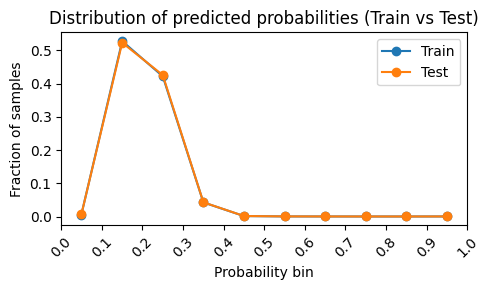

In [26]:
# PSI plot
plt.figure(figsize=(5, 3))
x_mid = df_test_bins['bin'].apply(lambda x: x.mid).to_numpy()
plt.plot(x_mid, df_train_bins['fraction_train'].to_numpy(), label='Train', marker='o')
plt.plot(x_mid, df_test_bins['fraction_test'].to_numpy(), label='Test', marker='o')

plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.01, 0.1))  # ticks at 0.0, 0.1, 0.2, ..., 1.0
plt.xlabel("Probability bin")
plt.ylabel("Fraction of samples")
plt.title("Distribution of predicted probabilities (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

**Figure 3:** Plot confirming the small PSI value (the training curve is barely visible). The plot also shows that most predicted probabilities lie between 0 and 0.5, reflecting the class imbalance (80% non-defaults).

### Calibration

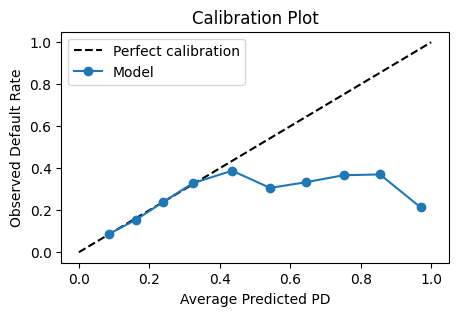

In [27]:
# Calibration
df_calibration = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

n_bins_cali = 10
bin_edges = np.linspace(0, 1, n_bins_cali + 1)

df_calibration["bin"] = pd.cut(df_calibration['y_pred_proba'], bins=bin_edges, include_lowest=True)
calibration_table = df_calibration.groupby('bin', observed=False).agg(
    avg_pred=('y_pred_proba', 'mean'),          # Average predicted PD in the bin
    obs_default_rate=('y_test', 'mean'),        # Fraction of defaults in the bin
).reset_index() # make the bins a column instead of index, and use standard index

plt.figure(figsize=(5,3))
plt.plot([0,1], [0,1], 'k--', label='Perfect calibration')
plt.plot(calibration_table['avg_pred'].to_numpy(), calibration_table['obs_default_rate'].to_numpy(), marker='o', label='Model')
plt.xlabel('Average Predicted PD')
plt.ylabel('Observed Default Rate')
plt.title('Calibration Plot')
plt.legend()
plt.show()

**Figure 4:** The calibration plot shows how well predicted probabilities correspond to the actual fraction of defaulters. For example, if the average predicted probability in the bin [0, 0.1] is 0.06, the fraction of actual defaulters among loans with predictions in [0, 0.1] should also be approximately 0.06.

As we can see, the calibration starts failing at the same spot as where the distribution of predicted probabilities (plot above) approaches zero. One reason for this is that since few samples are predicted with high probabilities, higher probability bins are more sensitive to non-default outliers with high predicted probabilities.

### Feature Importance

In [28]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

top_n_features = 5
feature_importance.head(top_n_features)

print(f"Top {top_n_features} features:\n")
for i in range(top_n_features):
    print(f"{feature_importance.iloc[i]['Feature']:<30}{feature_importance.iloc[i]['Coefficient']:.3f}")

Top 5 features:

dti                           0.272
purpose_debt_consolidation    0.195
purpose_small_business        0.102
purpose_other                 0.094
purpose_home_improvement      0.094
